# Indian Liver Patient Dataset
Data Spaces (01RLPOV), A.A. 2021/22  <br /> 
Politecnico di Torino - Corso di Laurea Magistrale in Ingegneria Informatica <br /> 
Elisa Cenedese - s255202 <br /> 
Link to data source: https://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29#

## Table of Contents

* [1. Introduction](#introduction)
    * [1.1 Attributes description](#attributes_descr)
    * [1.2 Basic dataset exploration](#basic_dataset_exploration)
    * [1.3 Check_for_missing_values](#check_missing_values)
    * [1.4 Check_for_outliers](#check_outliers)
    * [1.5 Split_dataset](#split_dataset)
* [2. Exploratory data analysis](#exploratory_data_analysis)
    * [2.1 Statistical quantitative description of features](#stat_features_descr)
    * [2.2 Box plots](#box_plots)
    * [2.3 Correlation analysis](#corr_analysis)
      * [2.3.1 Heatmap](#heatmap)
      * [2.3.2 Dendogram](#dendogram)

In [69]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
#Install
!pip install chart_studio
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
%matplotlib inline

#Imports
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import math
import pickle
from numpy import mean
from numpy import std
#plot libaries
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
import yaml
import pprint

from imblearn.over_sampling import SMOTENC
from matplotlib.colors import ListedColormap
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn import tree, svm, linear_model, ensemble, neighbors 
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.base import clone
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)
# online plotly
import chart_studio
chart_studio.tools.set_credentials_file(username='elisa_c', api_key='ixjDGQPn6k6yG1D96Wnr')
#chart_studio.tools.set_config_file(world_readable=False, sharing='secret')
import chart_studio.plotly as py
from scipy.cluster import hierarchy as hc

In [72]:
#Paths
DATA_FILE_NAME = "indian_liver_patient_dataset.csv"

ROOT_DIRPATH = os.path.join(
    '/content',
    'drive',
    'MyDrive',
    'DataSpaces',
    'DataSpaces_project',
)

DATA_DIRPATH = os.path.join(
    ROOT_DIRPATH,
    'data',
)

MODELS_DIRPATH = os.path.join(
    ROOT_DIRPATH,
    'models',
)

data_file_path = os.path.join(DATA_DIRPATH, DATA_FILE_NAME)

if not os.path.exists(MODELS_DIRPATH):
    os.makedirs(MODELS_DIRPATH)

In [73]:
def read_dataset(dirpath: str, file_type: str, sheet_name_=None):
  if file_type == "xlsx":
    dataset_df = pd.read_excel(dirpath, sheet_name= sheet_name_)
  elif file_type == "csv":
    with open(dirpath) as in_fp:
      dataset_df = pd.read_csv(in_fp, sep=',', header=0)
  else:
    raise Exception("Unrecognised dataset format")
  return dataset_df

In [74]:
def show_dict(dict_: dict):
    pprint.pprint(dict_, width=1)

In [75]:
def print_formatted_list(str_, list):
  print(str_ + ":")
  for value in list:
    print("  - " + str(value))
  print()

In [76]:
def prepare_bar_plot(df, title, template_):
  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  data_series = df.value_counts() # return series
  data = [go.Bar(x=data_series.index, y=data_series.values, marker = dict(color = colors[:len(data_series.index)]))]
  layout = go.Layout(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      title=title,
      template = template_,
      autosize=False,
      width=400,
      height=400,
      yaxis=dict(
          title='#samples',
      ),
  )
  fig = go.Figure(data=data, layout=layout)
  return fig, data_series

In [77]:
def prepare_histogram_plot(X, features_names, class_names, config_dict, template_, per_feature=True):
  start_pos = 0
  data = []
  num_steps = len(features_names)

  for count_class, target in enumerate(class_names):
    trace_list = []
    for count, feature in enumerate(features_names):
      if count != start_pos:
        trace_list.append(go.Histogram(x=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = False))
      else: 
        if per_feature and (count_class == 0 or count_class == 1):
            visibility_ =  True
        else:
            visibility_ =  'legendonly'
        trace_list.append(go.Histogram(x=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = visibility_))
    data = data + trace_list

  trace_list_all_classes = []
  for count, feature in enumerate(features_names):
      if count != start_pos:
        trace_list_all_classes.append(go.Histogram(x=X[feature], name = 'all', visible = False))
      else: 
        if per_feature:
          visibility_ =  'legendonly'
        else:
           visibility_ = True
        trace_list_all_classes.append(go.Histogram(x=X[feature], name = 'all', visible = visibility_))

  data = data + trace_list_all_classes

  steps = []

  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
          label = features_names[i],
      )

      # Enable the traces we want to see
      for count, class_name in enumerate(class_names):
        #print(i+count*len(features_names))
        if per_feature and (count == 0 or count == 1):
          visibility_ =  True
        else:
          visibility_ =  'legendonly'
        step['args'][1][i+count*len(features_names)] = visibility_
     
      if per_feature:
        visibility_ = 'legendonly'
      else:
        visibility_ = True
      step['args'][1][i+(count+1)*len(features_names)] = visibility_
      
      # Add step to step list
      steps.append(step)

  sliders = [dict(
      active = start_pos, # from where to start the slider
      currentvalue = dict(
          prefix = "Feature: ", 
          xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
  )]

  layout = dict(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      sliders=sliders,
      template = template_,  
      yaxis=dict(
          title='#Samples',
          automargin=True,
      ),
      #font=dict(
      #    color=font_color
      #)
  )

  return go.Figure(data=data, layout=layout)

In [78]:
def prepare_box_plot(X, features_names, class_names, config_dict, template_):
  active_pos = 0
  data = []
  num_steps = len(features_names)

  for target in class_names:
    trace_list = []
    for count, feature in enumerate(features_names):
      if count != active_pos:
        trace_list.append(go.Box(y=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = False))
      else:
         trace_list.append(go.Box(y=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = True))
    data = data + trace_list

  steps = []

  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
          label = features_names[i],
      )
      # Enable the two traces we want to see
      for count, class_name in enumerate(class_names):
        #print(i+count*len(features_names))
        step['args'][1][i+count*len(features_names)] = True
        
      # Add step to step list
      steps.append(step)

  sliders = [dict(
      active = active_pos,
      currentvalue = dict(
          prefix = "Feature: ", 
          xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
  )]

  layout = dict(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      sliders=sliders,
      template = template_,  
      yaxis=dict(
          title='Feature value',
          automargin=True,
      ),
      #font=dict(
      #    color=font_color
      #)
  )

  return go.Figure(data=data, layout=layout)

In [79]:
def prepare_dendogram(X, title_, template_):
  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  feature_names = X.columns
  inverse_correlation = 1 - abs(X.corr())

  fig = ff.create_dendrogram(inverse_correlation.values, orientation='left', labels=feature_names, colorscale=colors, linkagefun=lambda x: hc.linkage(x, 'average'))
  
  fig['layout'].update(dict(
      title= title_,
      template= template_,
      width=800, 
      height=600,
      margin=go.layout.Margin(l=180, r=50),
      xaxis=dict(
          title='distance',
      ),
      yaxis=dict(
          title='features',
          automargin=True,
      ),
  ))
  return fig

In [80]:
def prepare_heatmap(X, template_):
  corr = X.corr()
  trace = go.Heatmap(z=corr.values.tolist(), x=corr.columns, y=corr.columns)
  data=[trace]
  layout = go.Layout(
      title='Heatmap of pairwise correlation of the columns',
      autosize=False,
      template = template_,
      width=650,
      height=500,
      yaxis=go.layout.YAxis(automargin=True),
      xaxis=dict(tickangle=40),
      margin=go.layout.Margin(l=80, r=80, b=80, t=80)
  )

  return go.Figure(data=data, layout=layout)

In [81]:
def prepare_pairplot(X, config_dict, combinations, features_names, template_):
  trace_list = []
  combinations_names = []
  start_pos = 0
  index_vals = X[config_dict['TARGET_COLUMN_NAME']].astype('category').cat.codes

  #combinations = list(itertools.combinations(range(len(features_list)), 2))
  num_steps = len(combinations)

  for couple in combinations:
    tuple_ = (features_names[couple[0]], features_names[couple[1]])
    combinations_names.append(str(tuple_))

  for count, couple in enumerate(combinations):
    #print(features_names[couple[0]], features_names[couple[1]])
    if count == start_pos:
      visibility_ = True
    else:
      visibility_ = False
 
    trace_list.append(go.Splom(dimensions=[dict(label=features_names[couple[0]],
                                                values=X[features_names[couple[0]]]),
                                          dict(label=features_names[couple[1]],
                                          values=X[features_names[couple[1]]])],
                              diagonal_visible=False, # remove plots on diagonal
                              text=X[config_dict['TARGET_COLUMN_NAME']],
                              marker=dict(color=index_vals,
                                          showscale=False, # colors encode categorical variables
                                          line_color='white', line_width=0.5),
                              visible = visibility_))

  steps = []
  
  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(trace_list)],
          label = combinations_names[i],
      )

      # Enable the traces we want to see
      step['args'][1][i] = True
        
      # Add step to step list
      steps.append(step)
  
  sliders = [dict(
      active = start_pos, # from where to start the slider
      currentvalue = dict(
            prefix = "Features couple: ", 
            xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
    )]

  layout = dict(
        #paper_bgcolor='rgba(0,0,0,0)',
        #plot_bgcolor='rgba(0,0,0,0)',
        sliders=sliders,
        template = template_,  
        #font=dict(
        #    color=font_color
        #)
        width=600,
        height=600,
  )

  return go.Figure(data=trace_list, layout=layout)

In [82]:
def prepare_PCA_explained_variance_plot(pca, template_):
  #explained_variance_ratio_ is the percentage of variance explained by each of the selected components.
  '''
  fig = plt.figure()
  plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative variance")
  plt.plot(pca.explained_variance_ratio_, label="Component variance")
  plt.legend()
  plt.xlabel('Principal component')
  plt.ylabel('Explained variance ratio')
  '''
  cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

  found_explained_variance_ratio = 0.0
  found_pc_id = 0
  for pc_id, value in enumerate(cum_explained_variance_ratio):
    if value >= 0.95:
      found_explained_variance_ratio = value
      found_pc_id = pc_id +1
      break

  trace_cum_var_exp = go.Scatter(
    x=list(range(1, len(pca.explained_variance_ratio_) + 1)), 
    y=pca.explained_variance_ratio_,
    name="Component explained variance",
  )
  trace_ind_var_exp = go.Scatter(
      x=list(range(1, len(cum_explained_variance_ratio) + 1)),
      y=cum_explained_variance_ratio,
      name="Cumulative explained variance",
    )
  data = [trace_cum_var_exp, trace_ind_var_exp]
  layout = go.Layout(
      template = template_,
      title='Individual and Cumulative Explained Variance',
      autosize=True,
      yaxis=dict(
          title='Explained variance ratio',
      ),
      xaxis=dict(
          title="Principal component",
          dtick=1,
      )
  )
  
  fig = go.Figure(data=data, layout=layout)

  fig.add_vline(x=found_pc_id, line_width=2, line_dash="dash", line_color="green")
  fig.add_hline(y=found_explained_variance_ratio, line_width=2, line_dash="dash", line_color="green")
      
  return fig

In [83]:
def prepare_biplot(pca, X_pca_trasformed, y, features_names, template_):
  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

  fig = px.scatter(X_pca_trasformed, x=0, y=1, color=y)

  for i, feature in enumerate(features_names):
      fig.add_shape(
          type='line',
          x0=0, y0=0,
          x1=loadings[i, 0],
          y1=loadings[i, 1]
      )
      fig.add_annotation(
          x=loadings[i, 0],
          y=loadings[i, 1],
          ax=0, ay=0,
          xanchor="center",
          yanchor="bottom",
          text=feature,
      )

  fig.update_layout( # customize font and legend orientation & position
    template = template_,
    width=700,
    height=700,
    legend_title_text='Class'
  )

  return fig

In [176]:
def save(classifier, filepath):
  with open(filepath, "wb") as open_file:
    pickle.dump(classifier, open_file)

def load(filepath):
  with open(filepath, 'rb') as open_file:
      loaded_classifier = pickle.load(open_file)
  return loaded_classifier

def plot_PRC(clf_names, y_preds, y):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend(loc='lower right')
    ax.set_title("Precision-Recall Curves")
    for i, y_pr in enumerate(y_preds):
        metrics.PrecisionRecallDisplay.from_predictions(y, y_pr, name=clf_names[i], ax=ax)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    fig.show()

def plot_confusion_matrix(model, X, y, title='Confusion matrix'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    metrics.ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax)
    fig.show()
    #fig.savefig(filepath)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, model, features_pair, title, apply_PCA=False):
   
    X_train_ = X_train[features_pair]
    X_test_ = X_test[features_pair]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_)
    X_test_scaled = scaler.transform(X_test_)

    if apply_PCA:
      pca = PCA()
      X_train_scaled = pca.fit_transform(X_train_scaled)
      X_test_scaled = pca.transform(X_test_scaled)

    sm = SMOTE(sampling_strategy='not majority', random_state=config_dict['GENERAL']['SEED'])
    X_train_augm, y_train_augm = sm.fit_resample(X_train_scaled, y_train)

    print("Fitting...")
    clf = model.fit(X_train_augm, y_train_augm)

    print("DONE")

    fig, ax = plt.subplots()
    # title for the plots
    #title = ('Decision surface of linear SVC ')
    # Set-up grid for plotting.
    X0, X1 = X_train_augm[:, 0], X_train_augm[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_train_augm, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel('y label here')
    ax.set_xlabel('x label here')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_logistic_curve(logistic_classifier, feature, X, y):
  
    feature_id = [i for i, f in enumerate(logistic_classifier.best_model.named_steps['scaler'].get_feature_names_out()) if f==feature][0]
    X_scaled = logistic_classifier.best_model.named_steps['scaler'].transform(X)
    
    trained_model = logistic_classifier.best_model.named_steps[logistic_classifier.name]
    plt.figure()
    m = trained_model.coef_[0,feature_id]
    b = trained_model.intercept_[0]
    x_v = X_scaled[:,feature_id]
    max_x_v = max(x_v)
    min_x_v = min(x_v)
    x_v = x_v * (max_x_v-min_x_v) + min_x_v
    rescale_factor = max_x_v-min_x_v
    #generate values for curve overlay
    lgs_curve = lambda x: 1/(1 + math.e**((int(max_x_v)+10)*(m*(x-rescale_factor)+b)))         
    x_values = np.linspace(int(min_x_v)-10, int(max_x_v)+10, int(max_x_v)+10)
    y_values = lgs_curve(x_values)

    # x_labels = 
    # y_label = config_dict['DATA']['TARGET_COL']

    #plot it
        
    print(x_v.shape)
    print(y.values.ravel().shape)

    plt.plot(x_values, y_values)
    plt.scatter(x_v, y.values.ravel(), c='r', s=2)
    plt.xlabel(feature)
    plt.ylabel("Probability of Liver disease")

def plot_decision_tree(decision_tree_classifier, feature_names, target_name, max_depth=None):

  trained_model = decision_tree_classifier.best_model.named_steps[decision_tree_classifier.name]
  plt.figure(figsize=(40,40))
  tree.plot_tree(trained_model, fontsize=10, feature_names=feature_names, 
                 class_names=[f"Liver disease=False", f"Liver disease=True"], 
                 label='all', filled=True, rounded=True, max_depth=max_depth)
  plt.show()

class Classifier:

  def __init__(self, name, model, class_general_conf, params_grid, class_balancer, feature_scaler):
    self.name = name
    self.model = model
    self.score_metric = class_general_conf['score_metric']
    self.cv_inner = class_general_conf['cv_inner']
    self.cv_outer = class_general_conf['cv_outer']
    self.seed = class_general_conf['seed']
    self.params_grid = params_grid
    self.class_balancer = class_balancer
    self.feature_scaler = feature_scaler
    self.pipeline = None
    self.apply_PCA = False
    self.num_components = 0

    self.ncv_global_mean_score = 0.0
    self.ncv_global_std_score = 0.0
    self.ncv_test_outer_results = []
    self.ncv_train_outer_results = []
    self.ncv_best_hyperparams = []
    self.ncv_inner_results = []
    self.ncv_trained = False

    self.trained = False
    self.best_model = None
    self.best_param = {}
    self.y_pred = []

  def cv(self, X_train, X_test, y_train, y_test, apply_PCA=False, num_components=None):
    if apply_PCA:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                ('pca', PCA(n_components=num_components, random_state=self.seed)), 
                (self.name, self.model)
                ])
        self.apply_PCA = True
        self.num_components = num_components
    else:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                (self.name, self.model)
                ])
    
    cv_inner = StratifiedKFold(n_splits=self.cv_inner, shuffle=True, random_state=self.seed)
    #scorer = make_scorer(self.score_metric, average = 'weighted')
    search = GridSearchCV(estimator=self.pipeline, param_grid=self.params_grid, cv=cv_inner,
                          scoring=self.score_metric, refit=True, verbose=4)

    # execute search
    search.fit(X_train, y_train.values.ravel())
    # get the best performing model fit on the whole training set 
    self.best_model = search.best_estimator_ 
    self.best_param = search.best_params_
    best_score = search.best_score_

    self.trained = True

    print('>> Predicting on test dataset...')
    self.y_pred = search.predict(X_test)

    self.print_results(X_train, X_test, y_train, y_test)
  
  def print_results(self, X_train, X_test, y_train, y_test):

    if self.trained == False:
      print("Train model before. Invoce cv()")
      return
  
    print('Best hyperparameters:')
    print(display(pd.DataFrame(self.best_param, index=[0])))
    print()

    print("Test classification report")
    print(classification_report(y_test, self.y_pred))

    plot_confusion_matrix(self.best_model, X_test, y_test,
                          f"Confusion matrix with {self.name}{' + PCA' if self.apply_PCA else ''}")
    

  def print_nested_cv_results(self):
    if self.ncv_trained == False:
      print("Nested cv not already performed. Invoke nested_cv() first.")
      return

    num_it = len(self.ncv_inner_results) 

    for i in range(0, num_it):

        print('\n--------------------------------------------\n')
        print(f"Inner CV (Hyperparameters and model selection): ")
        print(f"  F1-score = {self.ncv_inner_results[i]}")
        print(f"  Best hyperparams = {self.ncv_best_hyperparams[i]}")
        print(f"Outer CV (Quality of model selection assessment): ")
        print(f"  F1-score = {self.ncv_test_outer_results[i]}")
        print('\n--------------------------------------------\n')

    global_mean_score = mean(self.ncv_test_outer_results)
    global_std_score = std(self.ncv_test_outer_results)
    global_train_score = mean(self.ncv_train_outer_results)
    global_train_std = std(self.ncv_train_outer_results)

    print('\n--------------------------------------------\n')
    print(f"Mean training F1-score = {str(global_train_score)} ({str(global_train_std)})")
    print(f"Mean validation F1-score = {str(global_mean_score)} ({str(global_std_score)})")
    
    print("List of best hyperparameters to check stability: ")
    
    best_hyperparams_dict = {}
    for best_hyps in self.ncv_best_hyperparams:
      for k,v in best_hyps.items():
        if k not in best_hyperparams_dict:
            best_hyperparams_dict[k] = [v]
        else:
            best_hyperparams_dict[k].append(v)
    print(display(pd.DataFrame.from_dict(best_hyperparams_dict)))

        
  def nested_cv(self, X, y, apply_PCA=False, num_components=None):
    if self.ncv_trained == True:
      print("Nested cv already performed")
      self.print_nested_cv_results()
      return

    if apply_PCA:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                ('pca', PCA(n_components=num_components, random_state=self.seed)), 
                (self.name, self.model)
                ])
        self.apply_PCA = True
        self.num_components = num_components
    else:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                (self.name, self.model)
                ])
        
    ##apply nested cross validation
    # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
    # the k-fold cross-validation procedure for model hyperparameter optimization is nested 
    # inside the k-fold cross-validation procedure for model selection. 
    # configure the outer cross-validation procedure to assess model performance
    cv_outer = StratifiedKFold(n_splits=self.cv_outer, shuffle=True, random_state=self.seed)

    for train_ix, test_ix in cv_outer.split(X, y):  # k outer folds, k = 10
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        print("Computing inner cross validation for grid search of best hyperparameters...")
        # configure the inner cross-validation procedure for grid search of best hyperparameters.  
        # selecting the best model (including parameters). 
        cv_inner = StratifiedKFold(n_splits=self.cv_inner, shuffle=True, random_state=self.seed)
        #scorer = make_scorer(self.score_metric, average = 'weighted')
        '''
        search = RandomizedSearchCV(estimator=self.pipeline, param_distributions=self.params_grid, 
                                    n_iter=20, cv=cv_inner, scoring=scorer, refit=True, verbose=2)
        '''
        search = GridSearchCV(estimator=self.pipeline, param_grid=self.params_grid, cv=cv_inner,
                              scoring=self.score_metric, refit=True, verbose=4)
        # refit = True --> configure the hyperparameter search to refit a final model
        # with the entire training dataset using the best hyperparameters found during the search.

        # execute search
        search.fit(X_train, y_train.values.ravel())
        # get the best performing model fit on the whole training set
        # This model can then be used to make predictions on the holdout data 
        # from the outer loop and estimate the performance of the model.
        best_model = search.best_estimator_ 
        best_param = search.best_params_
        best_score = search.best_score_
        
        # evaluate the performance of the model on the hold out data.
        #  you are not assessing just the quality of the model, but the quality of the procedure for model selection
        y_test_pred = search.predict(X_test)
        test_score = f1_score(y_test, y_test_pred)
        y_train_pred = search.predict(X_train)
        train_score = f1_score(y_train, y_train_pred)

        self.ncv_inner_results.append(best_score)
        self.ncv_test_outer_results.append(test_score)
        self.ncv_train_outer_results.append(train_score)
        self.ncv_best_hyperparams.append(best_param)
    
        print('\n--------------------------------------------\n')
        print(f"Inner CV (Hyperparameters and model selection): ")
        print(f"  F1-score = {best_score}")
        print(f"  Best hyperparams = {best_param}")
        print(f"Outer CV (Quality of model selection assessment): ")
        print(f"  F1-score = {test_score}")
        print('\n--------------------------------------------\n')

    self.ncv_global_mean_score = mean(self.ncv_test_outer_results)
    self.ncv_global_std_score = std(self.ncv_test_outer_results)
    global_train_score = mean(self.ncv_train_outer_results)
    global_train_std = std(self.ncv_train_outer_results)

    print('\n--------------------------------------------\n')
    print(f"Mean training F1-score = {str(global_train_score)} ({str(global_train_std)})")
    print(f"Mean validation F1-score = {str(self.ncv_global_mean_score)} ({str(self.ncv_global_std_score)})")
    
    print("List of best hyperparameters to check stability: ")
    
    best_hyperparams_dict = {}
    for best_hyps in self.ncv_best_hyperparams:
      for k,v in best_hyps.items():
        if k not in best_hyperparams_dict:
            best_hyperparams_dict[k] = [v]
        else:
            best_hyperparams_dict[k].append(v)
    print(display(pd.DataFrame.from_dict(best_hyperparams_dict)))

    self.ncv_trained = True

    return self.ncv_global_mean_score, self.ncv_global_std_score

In [85]:
config_dict = {}

config_dict['GENERAL'] = {
    'SEED': 42,
    'TARGET_COLUMN_NAME': "CLASS",
    'NUMERIC_FEATURES': ['Age','TB','DB','AAP','SGPT','SGOT','TP','ALBA','AGR'],
    'BOOLEAN_FEATURES': ['Gender'],
    'SHOW_METHOD': 0, # 0 for colab, 1 for plotly, 2 for static png figures
    'PERFORM_NCV': False
}

if config_dict['GENERAL']['SHOW_METHOD'] > 0:
  template_ =  'plotly_white'
else:
  template_ = 'plotly_dark'

show_dict(config_dict)

{'GENERAL': {'BOOLEAN_FEATURES': ['Gender'],
             'NUMERIC_FEATURES': ['Age',
                                  'TB',
                                  'DB',
                                  'AAP',
                                  'SGPT',
                                  'SGOT',
                                  'TP',
                                  'ALBA',
                                  'AGR'],
             'PERFORM_NCV': False,
             'SEED': 42,
             'SHOW_METHOD': 0,
             'TARGET_COLUMN_NAME': 'CLASS'}}


## 1. Introduction<a class="anchor" id="introduction"></a>

###1.1 Attributes description<a class="anchor" id="attributes_descr"></a>

###1.2 Basic dataset exploration<a class="anchor" id="basic_dataset_exploration"></a>

In [86]:
dataset_df = read_dataset(data_file_path, file_type= "csv")
dataset_df.loc[dataset_df['CLASS'] == 2, 'CLASS'] = 0

le = preprocessing.LabelEncoder()
dataset_df['Gender'] = le.fit_transform(dataset_df['Gender'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label encoding for Gender feature:")
print(le_name_mapping)

print(display(dataset_df.head()))

X = dataset_df.drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
y = dataset_df[config_dict['GENERAL']['TARGET_COLUMN_NAME']] # dataframe containing class column

features_names = X.columns.values
print_formatted_list("Feature names", features_names)
class_names = list(set(y))
print_formatted_list("Class names", class_names)

fig, data_series = prepare_bar_plot(y, title = "Distribution of samples per class", template_=template_)
print(f'\nNumber of samples = {dataset_df.shape[0]} | Number of features = {len(features_names)}\n')
for value in zip(data_series.values, data_series.index):
    print("%s: %d instances (%.2f%%)" % (value[1], value[0], (value[0]/y.shape[0])*100))
print()

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

Label encoding for Gender feature:
{'Female': 0, 'Male': 1}


,Age,Gender,TB,DB,AAP,SGPT,SGOT,TP,ALBA,AGR,CLASS
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


None
Feature names:
  - Age
  - Gender
  - TB
  - DB
  - AAP
  - SGPT
  - SGOT
  - TP
  - ALBA
  - AGR

Class names:
  - 0
  - 1


Number of samples = 583 | Number of features = 10

1: 416 instances (71.36%)
0: 167 instances (28.64%)



###1.3 Check for missing values<a class="anchor" id="check_missing_values"></a>
We can observe below that there are no missing values in the dataset.

In [87]:
# check for null values in the dataset
print("Missing values per feature:")
print(X.isna().sum())
print()
display(dataset_df.groupby('CLASS', as_index=False)['AGR'].min().rename(columns={'AGR': 'min(AGR)'}))
print()
display(dataset_df.groupby('CLASS', as_index=False)['AGR'].max().rename(columns={'AGR': 'max(AGR)'}))
print()
display(dataset_df.groupby('CLASS', as_index=False)['AGR'].mean().rename(columns={'AGR': 'mean(AGR)'}))

Missing values per feature:
Age       0
Gender    0
TB        0
DB        0
AAP       0
SGPT      0
SGOT      0
TP        0
ALBA      0
AGR       4
dtype: int64



,CLASS,min(AGR)
0,0,0.37
1,1,0.30


,CLASS,max(AGR)
0,0,1.9
1,1,2.8


,CLASS,mean(AGR)
0,0,1.029576
1,1,0.914179


In [88]:
dataset_df['AGR'].fillna(dataset_df.groupby('CLASS')['AGR'].transform('mean').round(2), inplace = True)
X = dataset_df.drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     583 non-null    int64  
 1   Gender  583 non-null    int64  
 2   TB      583 non-null    float64
 3   DB      583 non-null    float64
 4   AAP     583 non-null    int64  
 5   SGPT    583 non-null    int64  
 6   SGOT    583 non-null    int64  
 7   TP      583 non-null    float64
 8   ALBA    583 non-null    float64
 9   AGR     583 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 45.7 KB


###1.4 Checking for outliers<a class="anchor" id="check_outliers"></a>

In [89]:
fig = prepare_histogram_plot(dataset_df, features_names, class_names, config_dict['GENERAL'], template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

###1.5 Split dataset<a class="anchor" id="split_dataset"></a>

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=config_dict['GENERAL']['SEED'], stratify=y, shuffle=True)

##2. Exploratory data analysis<a class="anchor" id="exploratory_data_analysis"></a>

In [91]:
fig, data_series = prepare_bar_plot(y_train, title = "Training samples: distribution per class", template_=template_)
print(f'Training dataset length: {X_train.shape[0]}\n')
for value in zip(data_series.values, data_series.index):
    print("%s: %d instances (%.2f%%)" % (value[1], value[0], (value[0]/y_train.shape[0])*100))
print()

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot_training')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

Training dataset length: 466

1: 333 instances (71.46%)
0: 133 instances (28.54%)



In [92]:
fig, data_series = prepare_bar_plot(y_test, title = "Test samples: distribution per classs", template_=template_)
print(f'Test dataset length: {X_test.shape[0]}\n')
for value in zip(data_series.values, data_series.index):
    print("%s: %d instances (%.2f%%)" % (value[1], value[0], (value[0]/y_test.shape[0])*100))
print()

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot_test')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

Test dataset length: 117

1: 83 instances (70.94%)
0: 34 instances (29.06%)



###2.1 Statistical quantitative description of features<a class="anchor" id="stat_features_descr"></a>

Generate descriptive statistics.
For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles. By default the lower percentile is 25 and the upper percentile is 75. The 50 percentile is the same as the median.

In [93]:
print(display(X_train[config_dict['GENERAL']['NUMERIC_FEATURES']].describe()))

,Age,TB,DB,AAP,SGPT,SGOT,TP,ALBA,AGR
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,44.519313,2.976180,1.372961,294.019313,83.150215,103.881974,6.483906,3.153219,0.951288
std,16.000694,4.959016,2.558393,252.866027,193.080002,223.780425,1.078439,0.789283,0.315742
min,4.000000,0.400000,0.100000,75.000000,10.000000,10.000000,3.000000,1.000000,0.300000
25%,33.000000,0.800000,0.200000,176.250000,23.000000,25.000000,5.700000,2.600000,0.750000
50%,45.000000,1.000000,0.300000,208.500000,35.000000,41.000000,6.550000,3.100000,0.955000
75%,57.000000,2.600000,1.275000,298.000000,60.000000,83.750000,7.200000,3.800000,1.100000
max,90.000000,30.500000,17.100000,2110.000000,2000.000000,2946.000000,9.600000,5.500000,2.800000


None


In [94]:
X_train_class = X_train.copy()
X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] = y_train

liver_patients = X_train_class.loc[X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] == 1].drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
no_liver_patients = X_train_class.loc[X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] == 0].drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
print("Quantitaive description (class 1)")
print(display(liver_patients.describe())) # per class
print("Quantitaive description (class 0)")
print(display(no_liver_patients.describe())) # per class

Quantitaive description (class 1)


,Age,Gender,TB,DB,AAP,SGPT,SGOT,TP,ALBA,AGR
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,46.069069,0.780781,3.687988,1.750150,321.027027,102.405405,129.072072,6.452553,3.080480,0.924715
std,15.272565,0.414340,5.672341,2.921767,278.417455,224.982732,259.551387,1.070765,0.768983,0.323926
min,7.000000,0.000000,0.400000,0.100000,75.000000,12.000000,11.000000,3.000000,1.000000,0.300000
25%,34.000000,1.000000,0.800000,0.200000,185.000000,25.000000,28.000000,5.700000,2.600000,0.700000
50%,46.000000,1.000000,1.300000,0.500000,228.000000,40.000000,50.000000,6.600000,3.000000,0.900000
75%,58.000000,1.000000,3.300000,1.600000,316.000000,74.000000,104.000000,7.100000,3.700000,1.100000
max,90.000000,1.000000,30.500000,17.100000,2110.000000,2000.000000,2946.000000,9.600000,5.500000,2.800000


None
Quantitaive description (class 0)


,Age,Gender,TB,DB,AAP,SGPT,SGOT,TP,ALBA,AGR
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,40.639098,0.684211,1.193985,0.428571,226.398496,34.939850,40.812030,6.562406,3.335338,1.017820
std,17.146578,0.466587,1.107123,0.573476,154.385828,27.197304,36.922349,1.097559,0.812702,0.284675
min,4.000000,0.000000,0.500000,0.100000,90.000000,10.000000,10.000000,3.700000,1.400000,0.370000
25%,27.000000,0.000000,0.700000,0.200000,162.000000,20.000000,21.000000,5.900000,2.900000,0.900000
50%,38.000000,1.000000,0.800000,0.200000,188.000000,28.000000,30.000000,6.500000,3.300000,1.000000
75%,55.000000,1.000000,1.100000,0.400000,215.000000,37.000000,43.000000,7.400000,4.000000,1.200000
max,85.000000,1.000000,7.300000,3.600000,1580.000000,181.000000,285.000000,9.200000,5.000000,1.850000


None


###2.2 Box plots<a class="anchor" id="box_plots"></a>

We plot one box plot per numeric feature to visualize whether each feature presents different characteristics depending on the target class.

In [95]:
fig = prepare_box_plot(X_train_class, config_dict['GENERAL']['NUMERIC_FEATURES'], class_names, config_dict['GENERAL'], template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'box_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

In [96]:
X_train_class_scaled = X_train_class.copy()
X_train_class_scaled[features_names] = MinMaxScaler().fit_transform(X_train_class_scaled[features_names])
fig = prepare_box_plot(X_train_class_scaled, config_dict['GENERAL']['NUMERIC_FEATURES'], class_names, config_dict['GENERAL'], template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bo_plot_scaled')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

###2.3 Correlation analysis<a class="anchor" id="corr_analysis"></a>

In [97]:
fig = prepare_heatmap(X_train, template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'heatmap')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

In [98]:
fig = prepare_dendogram(X_train, title_ = "Dendrogram of clustering the features according to correlation", template_=template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'dendogram')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

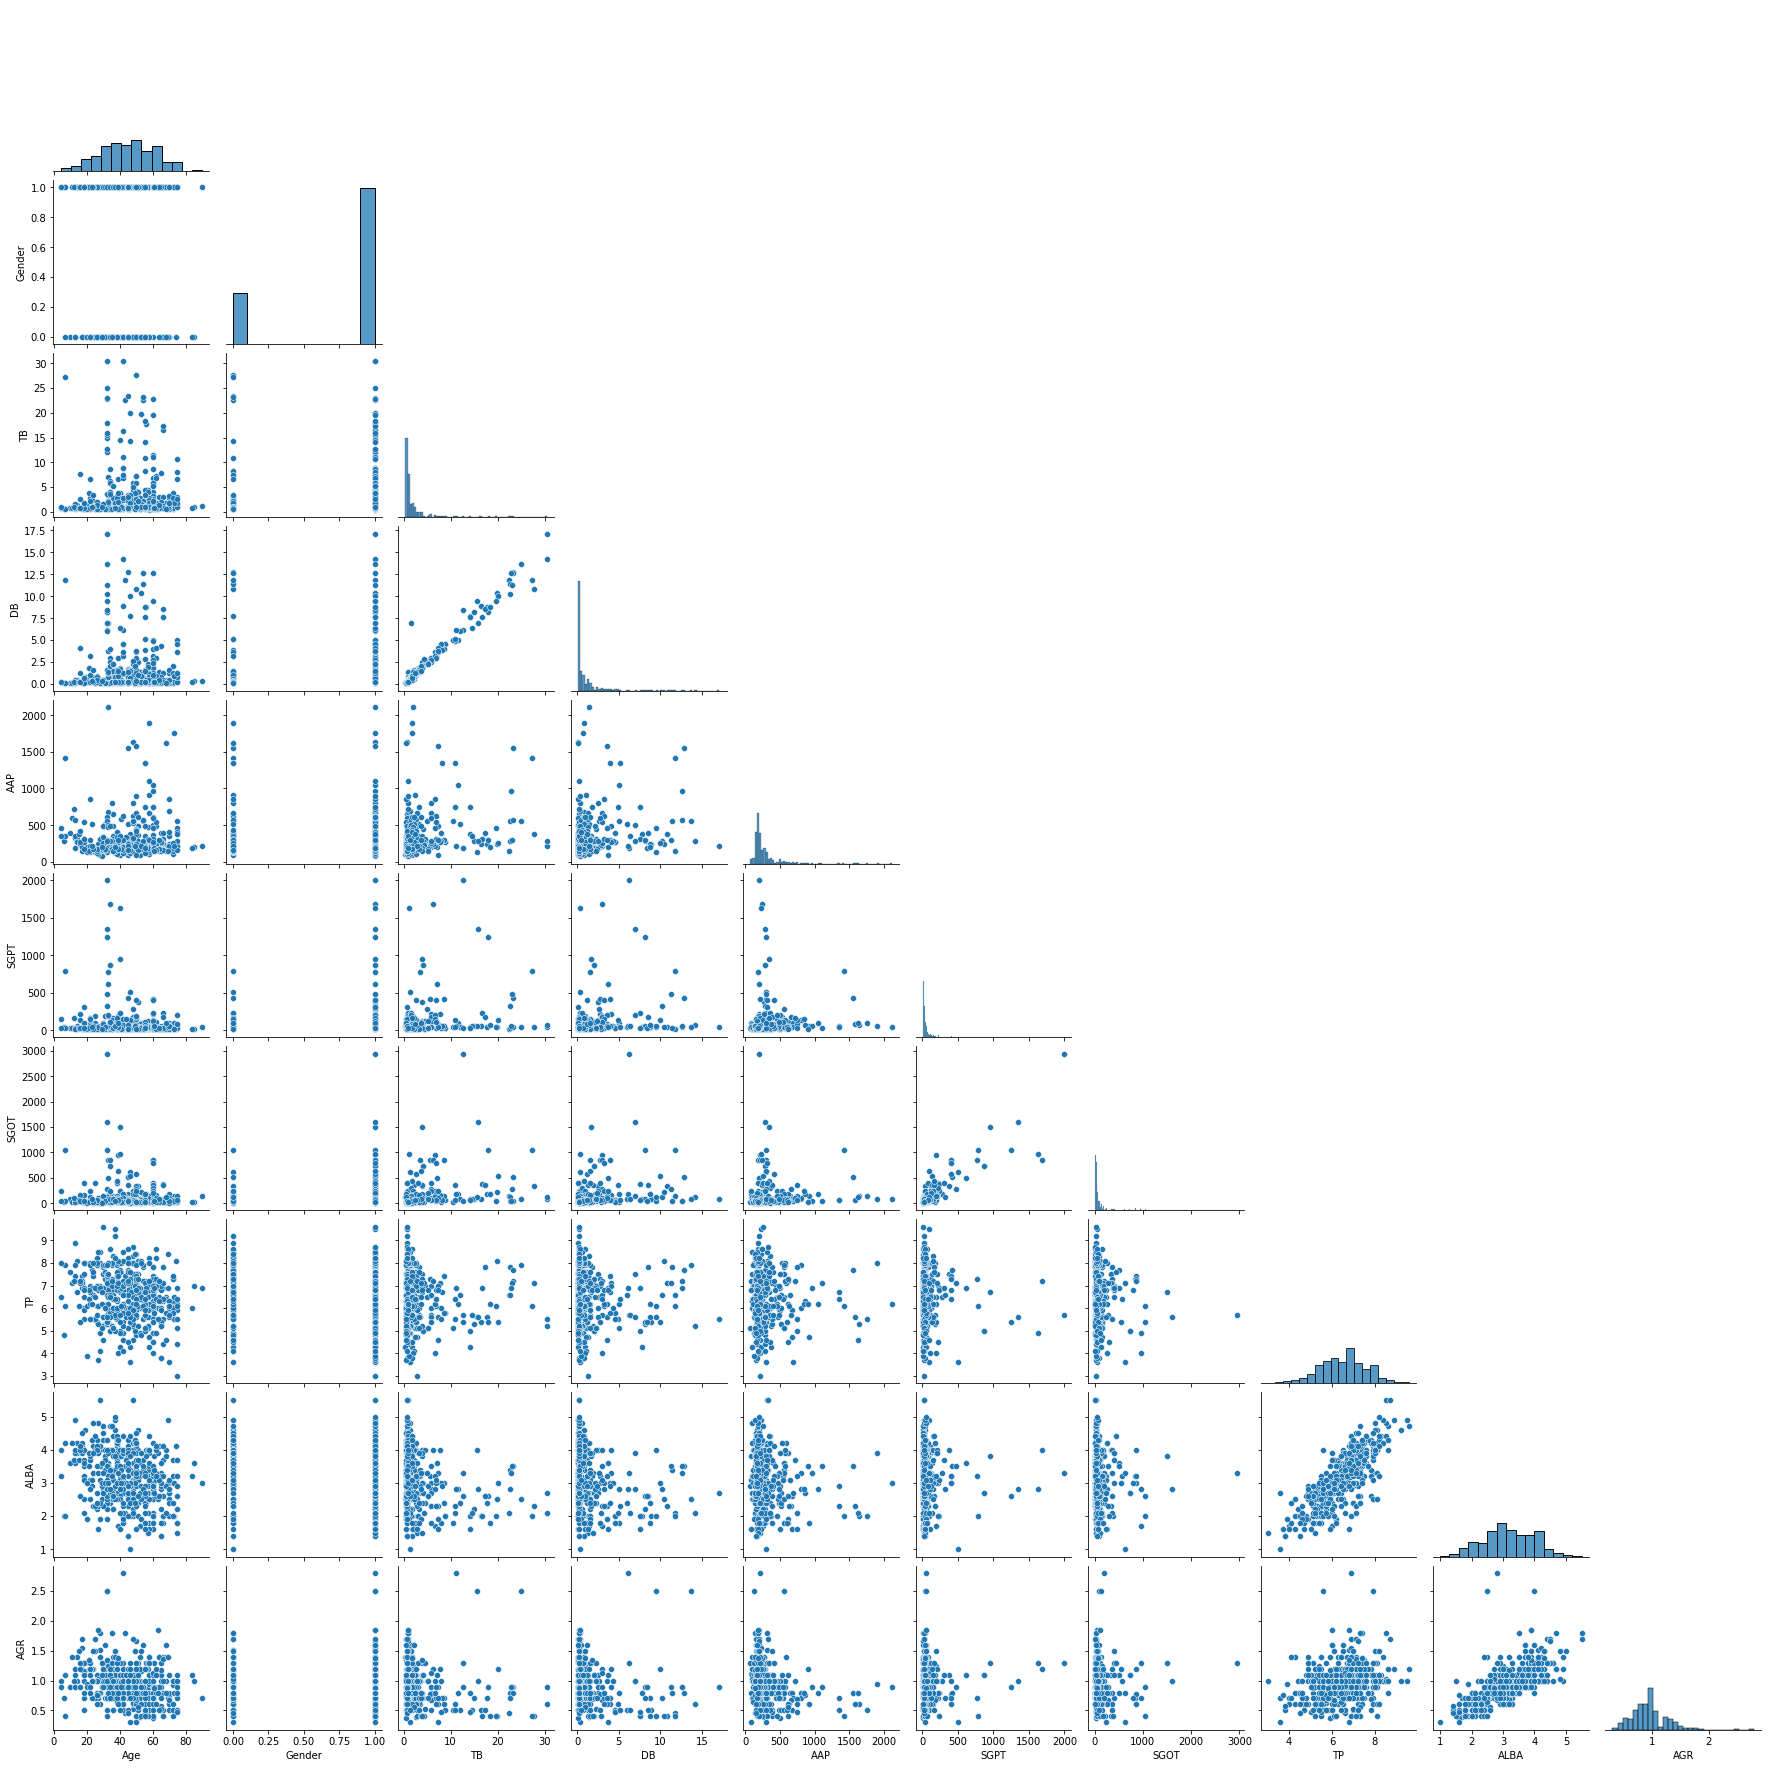

In [99]:
sns.pairplot(X_train, corner=True)
plt.show()

In [100]:
combinations = list(itertools.combinations(range(len(features_names)), 2))
fig = prepare_pairplot(X_train_class, config_dict['GENERAL'], combinations, features_names, template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'pair_plot1')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

##Preprocessing steps 

####Rebalancing

###Dimensionality reduction methods

#### Principal component analysis

In [101]:
X_train_scaled = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=len(features_names), random_state=config_dict['GENERAL']['SEED'])
X_train_pca_trasformed = pca.fit_transform(X_train_scaled)

In [102]:
fig = prepare_PCA_explained_variance_plot(pca, template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'explaied_variance')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

Loadings are visualized by arrows that are under an angle and have a certain length. The angle represents the contribution of a particular feature in the direction of the PCs where it contributes. The length of the arrow depicts the strength of the contribution of the feature in that direction.

In [103]:
fig = prepare_biplot(pca, X_train_pca_trasformed, y_train, features_names, template_)

if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bi_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')

In [104]:
loadings = pd.DataFrame(pca.components_.T[:, 0:2], columns=['PC1', 'PC2'], index=features_names)
loadings

,PC1,PC2
Age,0.112242,-0.298154
Gender,0.098340,-0.009278
TB,0.453956,0.204490
DB,0.444718,0.205593
AAP,0.230227,-0.011090
SGPT,0.293594,0.414125
SGOT,0.332129,0.396609
TP,-0.281027,0.389223
ALBA,-0.397403,0.454556
AGR,-0.295743,0.374026


In [105]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings[:, 0:2], columns=['PC1', 'PC2'], index=features_names)
loading_matrix

,PC1,PC2
Age,0.192074,-0.432884
Gender,0.168284,-0.013470
TB,0.776831,0.296896
DB,0.761022,0.298497
AAP,0.393975,-0.016101
SGPT,0.502412,0.601261
SGOT,0.568354,0.575830
TP,-0.480906,0.565105
ALBA,-0.680054,0.659962
AGR,-0.506089,0.543042


####Empirical feature selection

##Classification

###Metrics

###Cross validation

In [106]:
config_dict['CLASSIFICATION'] = {}

config_dict['CLASSIFICATION']['MODELS'] = {
        'LinearSVC': svm.SVC(kernel='linear'),
        'RbfSVC': svm.SVC(kernel='rbf'),
        'KNN': neighbors.KNeighborsClassifier(),
        'LogisticRegression': linear_model.LogisticRegression(),
        'DecisionTree': tree.DecisionTreeClassifier(),
        'RandomForest': ensemble.RandomForestClassifier(),
}

config_dict['CLASSIFICATION']['GENERAL'] = {
    'score_metric': 'f1',
    'cv_inner': 5,
    'cv_outer': 10,
    'seed': config_dict['GENERAL']['SEED']
}

config_dict['CLASSIFICATION']['PARAMS'] = {
    'KNN': {
            'KNN__n_neighbors' : list(range(1,35, 4)), 
            'KNN__weights': ['uniform', 'distance' ],
            #'KNN__n_jobs' : [-1],
            },
    'LinearSVC': {
            'LinearSVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            #'LinearSVC__kernel': ['linear'],  
            },
    'RbfSVC': {
            'RbfSVC__C': [10, 100, 1000],  
            'RbfSVC__gamma': [0.001, 0.01, 0.1, 1],    
            #'RbfSVC__kernel': ['rbf'],
            },
    'LogisticRegression': {
            'LogisticRegression__penalty': ['l1', 'l2'],
            'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],   
            'LogisticRegression__max_iter': [1000],
            'LogisticRegression__solver': ['liblinear'],
            },
    'DecisionTree': {
            'DecisionTree__max_depth': list(range(2, 10)),
            'DecisionTree__min_samples_split': list(range(2, 10)),
            'DecisionTree__criterion' : ['gini', 'entropy'],
            },
    'RandomForest': {
            'RandomForest__n_estimators': [10, 100],
            'RandomForest__criterion' : ['gini', 'entropy'],
            'RandomForest__max_depth': list(range(2, 10)),
            'RandomForest__min_samples_split': [2, 5, 10], 
            'RandomForest__max_features': ['sqrt'],
            #'RandomForest__n_jobs' : [-1],
            },
}

config_dict['CLASSIFICATION']['SCALER'] = {
    'StandardScaler' : ColumnTransformer(
            remainder='passthrough',
            transformers=[
                ("standardscaler", StandardScaler(), config_dict['GENERAL']['NUMERIC_FEATURES']),
            ],
            verbose_feature_names_out=False)
}

config_dict['CLASSIFICATION']['BALANCER'] = { 
    'SMOTENC' : SMOTENC(categorical_features=None, random_state=config_dict['GENERAL']['SEED'], sampling_strategy='not majority')
} 

show_dict(config_dict)

{'CLASSIFICATION': {'BALANCER': {'SMOTENC': SMOTENC(categorical_features=None, random_state=42,
        sampling_strategy='not majority')},
                    'GENERAL': {'cv_inner': 5,
                                'cv_outer': 10,
                                'score_metric': 'f1',
                                'seed': 42},
                    'MODELS': {'DecisionTree': DecisionTreeClassifier(),
                               'KNN': KNeighborsClassifier(),
                               'LinearSVC': SVC(kernel='linear'),
                               'LogisticRegression': LogisticRegression(),
                               'RandomForest': RandomForestClassifier(),
                               'RbfSVC': SVC()},
                    'PARAMS': {'DecisionTree': {'DecisionTree__criterion': ['gini',
                                                                            'entropy'],
                                                'DecisionTree__max_depth': [2,
                 

In [107]:
pd.DataFrame.from_dict(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], columns = ['LinearSVC__C'])).T

,0,1,2,3,4,5,6
LinearSVC__C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0


In [108]:
pd.DataFrame.from_dict(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RbfSVC']['RbfSVC__C'], columns = ['RbfSVC__C'])).T

,0,1,2
RbfSVC__C,10,100,1000


In [109]:
pd.DataFrame.from_dict(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RbfSVC']['RbfSVC__gamma'], columns = ['RbfSVC__gamma'])).T

,0,1,2,3
RbfSVC__gamma,0.001,0.01,0.1,1.0


In [110]:
feature_scaler = config_dict['CLASSIFICATION']['SCALER']['StandardScaler']
feature_scaler1 = clone(feature_scaler)
_ = feature_scaler1.fit_transform(X_train) # to retreive the categorical features indices (order of columns is modified by the scaler)

#set categorical features indices
class_balancer = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])

num_components = 7

In [111]:
classifiers = []

###Support vector machines


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6324372912487366
  Best hyperparams = {'LinearSVC__C': 1}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.5306122448979592

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6270519283457905
  Best hyperparams = {'LinearSVC__C': 100}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.679245283018868

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6480843299583553
  Best hyperparams = {'LinearSVC__C': 10}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.75

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6293

,LinearSVC__C
0,1
1,100
2,10
3,10
4,1
5,1
6,10
7,1
8,1000
9,10


None
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.164 total time=   0.2s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.341 total time=   0.1s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.237 total time=   0.1s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.350 total time=   0.1s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.414 total time=   0.1s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.477 total time=   0.1s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.606 total time=   0.1s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.442 total time=   0.1s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.542 total time=   0.1s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.627 total time=   0.1s
[CV 1/5] END ..................LinearSVC__C=0.1;, score=0.606 total time=   0.1s
[CV 2/5] END ..................LinearSVC__C=

,LinearSVC__C
0,1000


None

Test classification report
              precision    recall  f1-score   support

           0       0.46      0.91      0.61        34
           1       0.94      0.57      0.71        83

    accuracy                           0.67       117
   macro avg       0.70      0.74      0.66       117
weighted avg       0.80      0.67      0.68       117



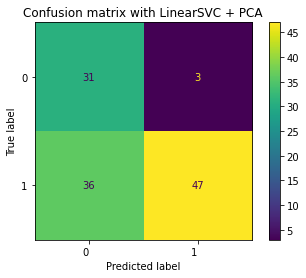

In [112]:
linear_svm_classifier_pca = Classifier('LinearSVC', config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                              config_dict['CLASSIFICATION']['GENERAL'], 
                              config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                              class_balancer, 
                              feature_scaler)
file_name = f'{linear_svm_classifier_pca.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_pca_mean_score, linear_svm_pca_std_score = linear_svm_classifier_pca.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(linear_svm_classifier_pca, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier_pca = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier_pca.print_nested_cv_results()

classifiers.append(linear_svm_classifier_pca)
linear_svm_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True, num_components=num_components)

In [113]:
X_test

,Age,Gender,TB,DB,AAP,SGPT,SGOT,TP,ALBA,AGR
70,19,0,0.7,0.2,186,166,397,5.5,3.0,1.20
61,58,1,1.0,0.5,158,37,43,7.2,3.6,1.00
252,65,1,1.1,0.3,258,48,40,7.0,3.9,1.20
136,46,0,4.7,2.2,310,62,90,6.4,2.5,0.60
396,74,1,1.0,0.3,175,30,32,6.4,3.4,1.10
...,...,...,...,...,...,...,...,...,...,...
195,60,1,2.4,1.0,1124,30,54,5.2,1.9,0.50
276,35,1,0.9,0.2,190,25,20,6.4,3.6,1.20
549,40,0,2.1,1.0,768,74,141,7.8,4.9,1.60
444,61,1,0.8,0.2,163,18,19,6.3,2.8,0.80


{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting...
DONE


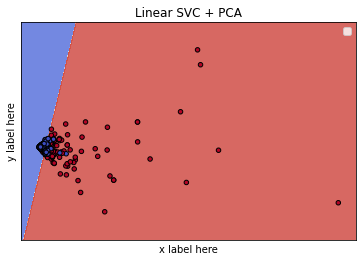

In [114]:
params = linear_svm_classifier_pca.best_model.named_steps[linear_svm_classifier_pca.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['SGPT','SGOT'], title="Linear SVC + PCA", apply_PCA=True)



--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6339878225022495
  Best hyperparams = {'LinearSVC__C': 10}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.56

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6144557705198437
  Best hyperparams = {'LinearSVC__C': 100}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.627450980392157

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6422813046361608
  Best hyperparams = {'LinearSVC__C': 10}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.7272727272727274

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.637

,LinearSVC__C
0,10
1,100
2,10
3,1
4,100
5,1
6,1
7,10
8,10
9,1


None
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ................LinearSVC__C=0.001;, score=0.164 total time=   0.1s
[CV 2/5] END ................LinearSVC__C=0.001;, score=0.341 total time=   0.0s
[CV 3/5] END ................LinearSVC__C=0.001;, score=0.237 total time=   0.0s
[CV 4/5] END ................LinearSVC__C=0.001;, score=0.350 total time=   0.0s
[CV 5/5] END ................LinearSVC__C=0.001;, score=0.414 total time=   0.0s
[CV 1/5] END .................LinearSVC__C=0.01;, score=0.460 total time=   0.0s
[CV 2/5] END .................LinearSVC__C=0.01;, score=0.606 total time=   0.0s
[CV 3/5] END .................LinearSVC__C=0.01;, score=0.442 total time=   0.0s
[CV 4/5] END .................LinearSVC__C=0.01;, score=0.542 total time=   0.0s
[CV 5/5] END .................LinearSVC__C=0.01;, score=0.627 total time=   0.0s
[CV 1/5] END ..................LinearSVC__C=0.1;, score=0.571 total time=   0.0s
[CV 2/5] END ..................LinearSVC__C=

,LinearSVC__C
0,1000


None

Test classification report
              precision    recall  f1-score   support

           0       0.47      0.91      0.62        34
           1       0.94      0.58      0.72        83

    accuracy                           0.68       117
   macro avg       0.71      0.75      0.67       117
weighted avg       0.80      0.68      0.69       117



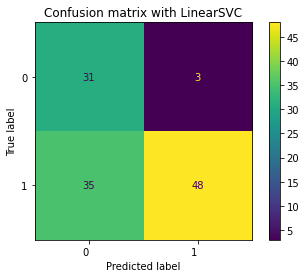

In [115]:
linear_svm_classifier = Classifier('LinearSVC', config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{linear_svm_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_mean_score, linear_svm_std_score = linear_svm_classifier.nested_cv(X_train, y_train, apply_PCA=False)
  save(linear_svm_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier.print_nested_cv_results()

classifiers.append(linear_svm_classifier)
linear_svm_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)

{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting...
DONE


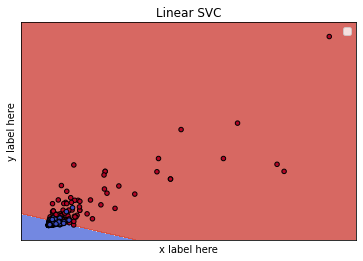

In [116]:
params = linear_svm_classifier.best_model.named_steps[linear_svm_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['SGPT','SGOT'], title="Linear SVC", apply_PCA=False)



--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7745469855250559
  Best hyperparams = {'RbfSVC__C': 100, 'RbfSVC__gamma': 1}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.746268656716418

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7453674219093989
  Best hyperparams = {'RbfSVC__C': 10, 'RbfSVC__gamma': 1}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.8169014084507041

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.784594630433435
  Best hyperparams = {'RbfSVC__C': 100, 'RbfSVC__gamma': 1}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.7076923076923077

--------------------------------------------


--------------------------------------------

In

,RbfSVC__C,RbfSVC__gamma
0,100,1
1,10,1
2,100,1
3,10,1
4,10,1
5,1000,1
6,100,1
7,1000,1
8,1000,1
9,10,1


None
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .RbfSVC__C=10, RbfSVC__gamma=0.001;, score=0.538 total time=   0.1s
[CV 2/5] END .RbfSVC__C=10, RbfSVC__gamma=0.001;, score=0.647 total time=   0.1s
[CV 3/5] END .RbfSVC__C=10, RbfSVC__gamma=0.001;, score=0.424 total time=   0.0s
[CV 4/5] END .RbfSVC__C=10, RbfSVC__gamma=0.001;, score=0.571 total time=   0.0s
[CV 5/5] END .RbfSVC__C=10, RbfSVC__gamma=0.001;, score=0.660 total time=   0.0s
[CV 1/5] END ..RbfSVC__C=10, RbfSVC__gamma=0.01;, score=0.571 total time=   0.0s
[CV 2/5] END ..RbfSVC__C=10, RbfSVC__gamma=0.01;, score=0.673 total time=   0.0s
[CV 3/5] END ..RbfSVC__C=10, RbfSVC__gamma=0.01;, score=0.495 total time=   0.0s
[CV 4/5] END ..RbfSVC__C=10, RbfSVC__gamma=0.01;, score=0.615 total time=   0.0s
[CV 5/5] END ..RbfSVC__C=10, RbfSVC__gamma=0.01;, score=0.697 total time=   0.0s
[CV 1/5] END ...RbfSVC__C=10, RbfSVC__gamma=0.1;, score=0.684 total time=   0.0s
[CV 2/5] END ...RbfSVC__C=10, RbfSVC__gamma

,RbfSVC__C,RbfSVC__gamma
0,10,1


None

Test classification report
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        34
           1       0.78      0.82      0.80        83

    accuracy                           0.71       117
   macro avg       0.64      0.63      0.63       117
weighted avg       0.70      0.71      0.70       117



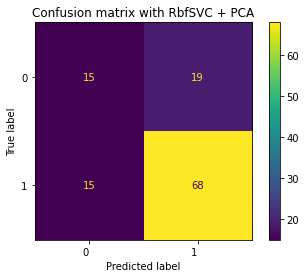

In [117]:
rbf_svm_classifier = Classifier('RbfSVC', config_dict['CLASSIFICATION']['MODELS']['RbfSVC'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['RbfSVC'], 
                            class_balancer, 
                            feature_scaler)

file_name = f'{rbf_svm_classifier.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  rbf_svm_mean_score, rbf_svm_std_score = rbf_svm_classifier.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(rbf_svm_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  rbf_svm_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  rbf_svm_classifier.print_nested_cv_results()

classifiers.append(rbf_svm_classifier)
rbf_svm_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Fitting...
DONE


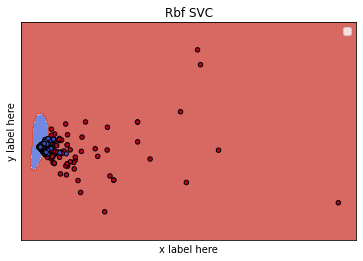

In [118]:
params = rbf_svm_classifier.best_model.named_steps[rbf_svm_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=True)

###KNN


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7284601662973754
  Best hyperparams = {'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.6875

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7140151917533775
  Best hyperparams = {'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.8125

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7541515739141611
  Best hyperparams = {'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.7384615384615385

--------------------------------------------


---------------------------------

,KNN__n_neighbors,KNN__weights
0,1,uniform
1,1,uniform
2,1,uniform
3,1,uniform
4,1,uniform
5,1,uniform
6,5,uniform
7,1,uniform
8,1,uniform
9,1,uniform


None
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.730 total time=   0.1s
[CV 2/5] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.760 total time=   0.0s
[CV 3/5] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.667 total time=   0.0s
[CV 4/5] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.688 total time=   0.0s
[CV 5/5] END KNN__n_neighbors=1, KNN__weights=uniform;, score=0.744 total time=   0.0s
[CV 1/5] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.730 total time=   0.0s
[CV 2/5] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.760 total time=   0.0s
[CV 3/5] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.667 total time=   0.0s
[CV 4/5] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.688 total time=   0.0s
[CV 5/5] END KNN__n_neighbors=1, KNN__weights=distance;, score=0.744 total time=   0.0s
[CV 1/5] END KNN__n_neighbors=5, KNN__weights=uniform;, sco

,KNN__n_neighbors,KNN__weights
0,1,uniform


None

Test classification report
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        34
           1       0.82      0.78      0.80        83

    accuracy                           0.73       117
   macro avg       0.67      0.69      0.68       117
weighted avg       0.74      0.73      0.73       117



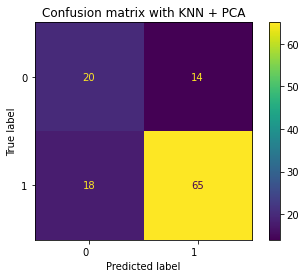

In [119]:
knn_classifier = Classifier('KNN', config_dict['CLASSIFICATION']['MODELS']['KNN'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['KNN'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{knn_classifier.name}_PCA.pkl'

if  config_dict['GENERAL']['PERFORM_NCV']:
  knn_mean_score, knn_std_score = knn_classifier.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(knn_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  knn_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  knn_classifier.print_nested_cv_results()

classifiers.append(knn_classifier)
knn_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
Fitting...
DONE


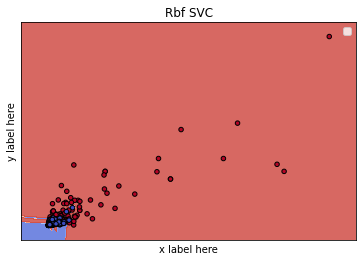

In [120]:
params = knn_classifier.best_model.named_steps[knn_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, neighbors.KNeighborsClassifier(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=False)

###Logistic Regression


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6757681268126813
  Best hyperparams = {'LogisticRegression__C': 10, 'LogisticRegression__max_iter': 1000, 'LogisticRegression__penalty': 'l1', 'LogisticRegression__solver': 'liblinear'}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.5490196078431372

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6750046271806823
  Best hyperparams = {'LogisticRegression__C': 0.01, 'LogisticRegression__max_iter': 1000, 'LogisticRegression__penalty': 'l1', 'LogisticRegression__solver': 'liblinear'}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.7692307692307693

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.6918643555756958
  Best hyperpara

,LogisticRegression__C,LogisticRegression__max_iter,LogisticRegression__penalty,LogisticRegression__solver
0,10.00,1000,l1,liblinear
1,0.01,1000,l1,liblinear
2,1.00,1000,l2,liblinear
3,0.01,1000,l1,liblinear
4,1.00,1000,l2,liblinear
5,1000.00,1000,l1,liblinear
6,0.01,1000,l1,liblinear
7,10.00,1000,l2,liblinear
8,0.01,1000,l1,liblinear
9,0.01,1000,l1,liblinear


None
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END LogisticRegression__C=0.001, LogisticRegression__max_iter=1000, LogisticRegression__penalty=l1, LogisticRegression__solver=liblinear;, score=0.000 total time=   0.1s
[CV 2/5] END LogisticRegression__C=0.001, LogisticRegression__max_iter=1000, LogisticRegression__penalty=l1, LogisticRegression__solver=liblinear;, score=0.000 total time=   0.0s
[CV 3/5] END LogisticRegression__C=0.001, LogisticRegression__max_iter=1000, LogisticRegression__penalty=l1, LogisticRegression__solver=liblinear;, score=0.000 total time=   0.0s
[CV 4/5] END LogisticRegression__C=0.001, LogisticRegression__max_iter=1000, LogisticRegression__penalty=l1, LogisticRegression__solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END LogisticRegression__C=0.001, LogisticRegression__max_iter=1000, LogisticRegression__penalty=l1, LogisticRegression__solver=liblinear;, score=0.000 total time=   0.0s
[CV 1/5] END LogisticRegression__C=0.00

,LogisticRegression__C,LogisticRegression__max_iter,LogisticRegression__penalty,LogisticRegression__solver
0,10,1000,l2,liblinear


None

Test classification report
              precision    recall  f1-score   support

           0       0.52      0.88      0.65        34
           1       0.93      0.66      0.77        83

    accuracy                           0.73       117
   macro avg       0.72      0.77      0.71       117
weighted avg       0.81      0.73      0.74       117



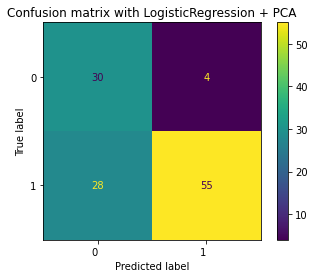

In [121]:
logistic_classifier = Classifier('LogisticRegression', config_dict['CLASSIFICATION']['MODELS']['LogisticRegression'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{logistic_classifier.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  logistic_mean_score, logistic_std_score = logistic_classifier.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(logistic_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  logistic_classifier = load( os.path.join(MODELS_DIRPATH, file_name))
  logistic_classifier.print_nested_cv_results()

classifiers.append(logistic_classifier)
logistic_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

{'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Fitting...
DONE


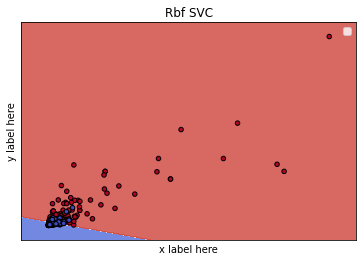

In [122]:
params = logistic_classifier.best_model.named_steps[logistic_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, linear_model.LogisticRegression(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=False)

(117,)
(117,)


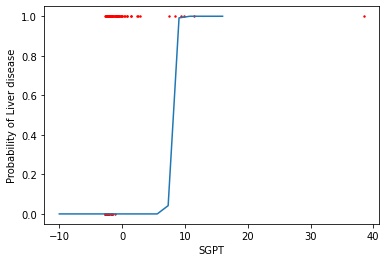

In [161]:
plot_logistic_curve(logistic_classifier, "SGPT", X_test, y_test)

###Decision tree


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7510481331533964
  Best hyperparams = {'DecisionTree__criterion': 'gini', 'DecisionTree__max_depth': 9, 'DecisionTree__min_samples_split': 2}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.787878787878788

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7257792734542321
  Best hyperparams = {'DecisionTree__criterion': 'entropy', 'DecisionTree__max_depth': 9, 'DecisionTree__min_samples_split': 4}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.78125

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.744272327332722
  Best hyperparams = {'DecisionTree__criterion': 'gini', 'DecisionTree__max_depth': 9, 'DecisionTree__min_samples_sp

,DecisionTree__criterion,DecisionTree__max_depth,DecisionTree__min_samples_split
0,gini,9,2
1,entropy,9,4
2,gini,9,4
3,gini,9,3
4,entropy,9,8
5,entropy,9,5
6,gini,9,2
7,gini,9,2
8,entropy,9,4
9,gini,9,4


None
Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END DecisionTree__criterion=gini, DecisionTree__max_depth=2, DecisionTree__min_samples_split=2;, score=0.636 total time=   0.1s
[CV 2/5] END DecisionTree__criterion=gini, DecisionTree__max_depth=2, DecisionTree__min_samples_split=2;, score=0.673 total time=   0.0s
[CV 3/5] END DecisionTree__criterion=gini, DecisionTree__max_depth=2, DecisionTree__min_samples_split=2;, score=0.600 total time=   0.0s
[CV 4/5] END DecisionTree__criterion=gini, DecisionTree__max_depth=2, DecisionTree__min_samples_split=2;, score=0.547 total time=   0.0s
[CV 5/5] END DecisionTree__criterion=gini, DecisionTree__max_depth=2, DecisionTree__min_samples_split=2;, score=0.697 total time=   0.0s
[CV 1/5] END DecisionTree__criterion=gini, DecisionTree__max_depth=2, DecisionTree__min_samples_split=3;, score=0.636 total time=   0.0s
[CV 2/5] END DecisionTree__criterion=gini, DecisionTree__max_depth=2, DecisionTree__min_samples_split=3;, scor

,DecisionTree__criterion,DecisionTree__max_depth,DecisionTree__min_samples_split
0,gini,9,2


None

Test classification report
              precision    recall  f1-score   support

           0       0.49      0.56      0.52        34
           1       0.81      0.76      0.78        83

    accuracy                           0.70       117
   macro avg       0.65      0.66      0.65       117
weighted avg       0.71      0.70      0.71       117



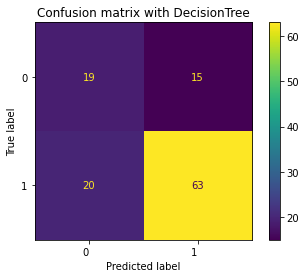

In [166]:
decision_tree_classifier = Classifier('DecisionTree', config_dict['CLASSIFICATION']['MODELS']['DecisionTree'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['DecisionTree'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{decision_tree_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  decision_tree_mean_score, decision_tree_std_score = decision_tree_classifier.nested_cv(X_train, y_train, apply_PCA=False, num_components=num_components)
  save(decision_tree_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  decision_tree_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  decision_tree_classifier.print_nested_cv_results()

classifiers.append(decision_tree_classifier)
decision_tree_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Fitting...
DONE


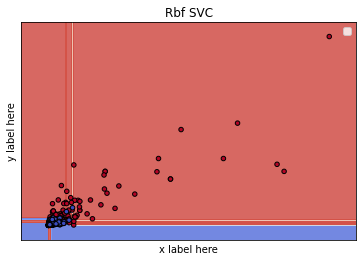

In [169]:
params = decision_tree_classifier.best_model.named_steps[decision_tree_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, tree.DecisionTreeClassifier(**params), 
                              features_pair=['SGPT','SGOT'], title="Rbf SVC", apply_PCA=False)

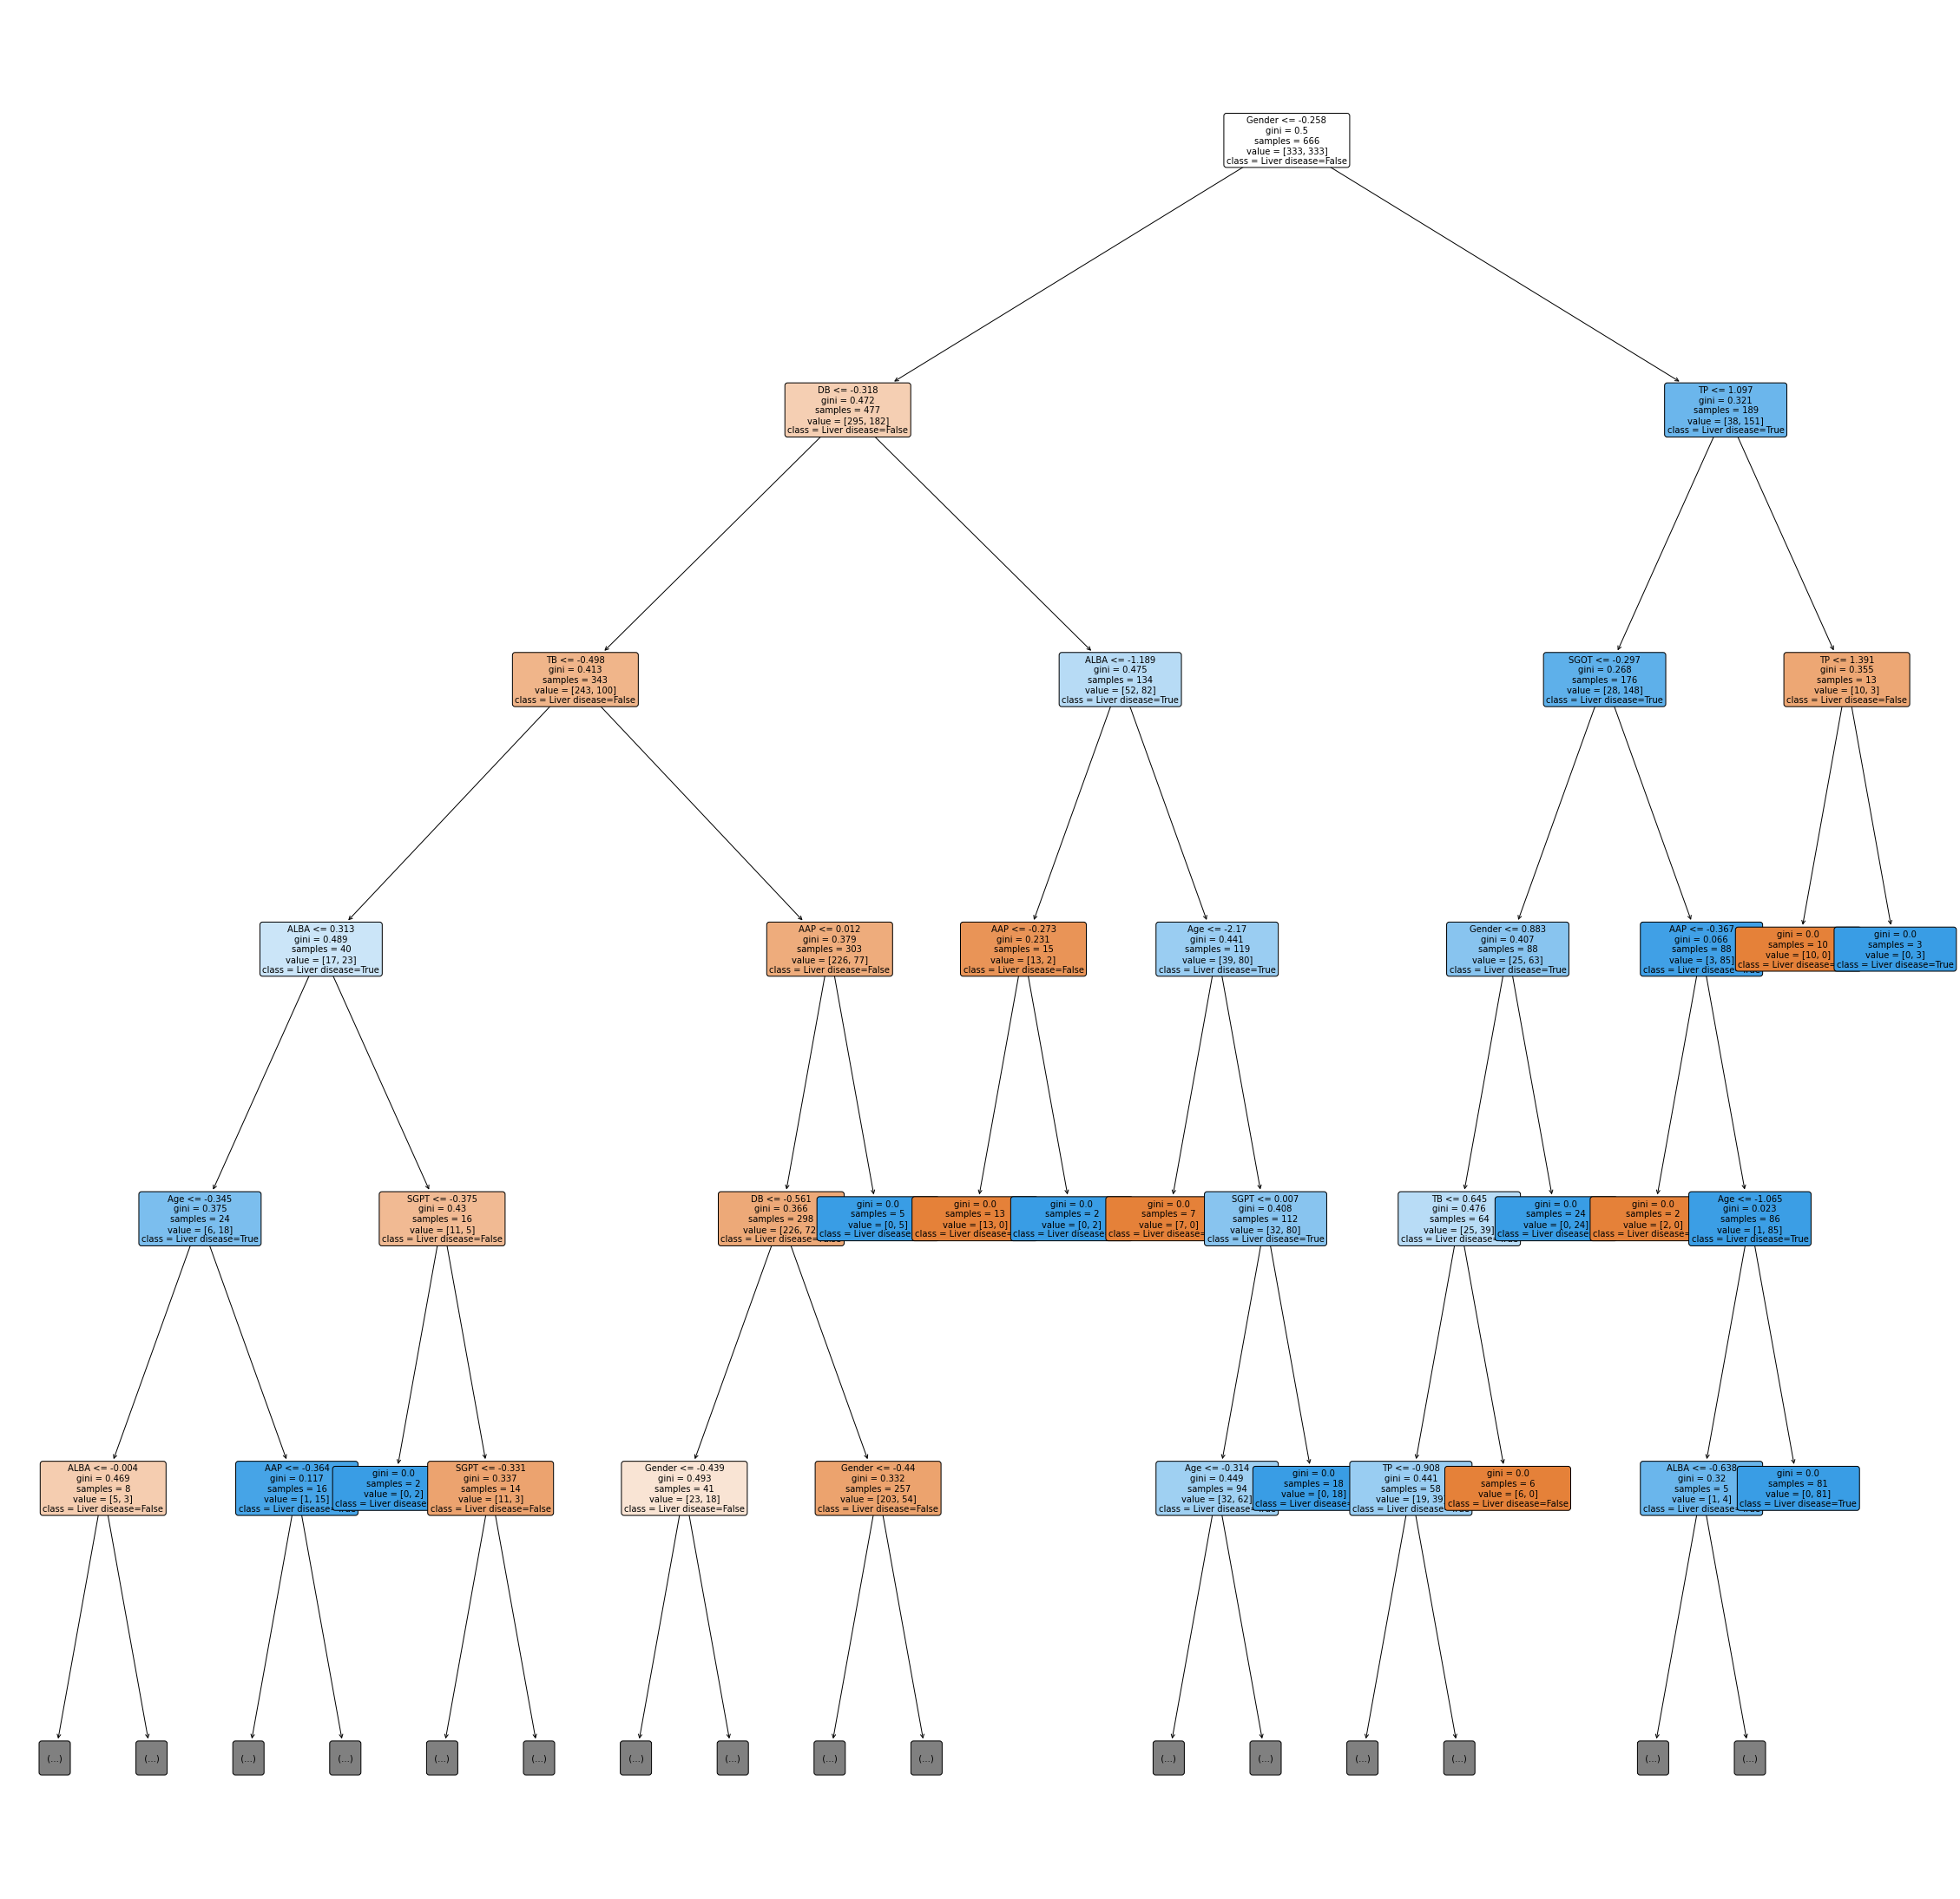

In [178]:
plot_decision_tree(decision_tree_classifier, features_names, config_dict['GENERAL']['TARGET_COLUMN_NAME'], max_depth=5) # max_depth=None to show full tree

###Random forest

In [126]:
random_forest_classifier = Classifier('RandomForest', config_dict['CLASSIFICATION']['MODELS']['RandomForest'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['RandomForest'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{random_forest_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  random_forest_score, random_forset_std_score = random_forest_classifier.nested_cv(X_train, y_train, apply_PCA=False, num_components=num_components)
  save(random_forest_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  random_forest_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  random_forest_classifier.print_nested_cv_results()

classifiers.append(random_forest_classifier)
random_forest_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7875052725052725
  Best hyperparams = {'RandomForest__criterion': 'gini', 'RandomForest__max_depth': 9, 'RandomForest__max_features': 'sqrt', 'RandomForest__min_samples_split': 5, 'RandomForest__n_estimators': 10}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.6774193548387097

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selection): 
  F1-score = 0.7558873921777148
  Best hyperparams = {'RandomForest__criterion': 'gini', 'RandomForest__max_depth': 9, 'RandomForest__max_features': 'sqrt', 'RandomForest__min_samples_split': 10, 'RandomForest__n_estimators': 10}
Outer CV (Quality of model selection assessment): 
  F1-score = 0.787878787878788

--------------------------------------------


--------------------------------------------

Inner CV (Hyperparameters and model selecti

,RandomForest__criterion,RandomForest__max_depth,RandomForest__max_features,RandomForest__min_samples_split,RandomForest__n_estimators
0,gini,9,sqrt,5,10
1,gini,9,sqrt,10,10
2,gini,8,sqrt,2,10
3,gini,9,sqrt,10,10
4,gini,9,sqrt,5,10
5,gini,9,sqrt,2,100
6,gini,9,sqrt,5,10
7,gini,7,sqrt,2,100
8,gini,8,sqrt,5,10
9,entropy,7,sqrt,2,10


None
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END RandomForest__criterion=gini, RandomForest__max_depth=2, RandomForest__max_features=sqrt, RandomForest__min_samples_split=2, RandomForest__n_estimators=10;, score=0.615 total time=   0.1s
[CV 2/5] END RandomForest__criterion=gini, RandomForest__max_depth=2, RandomForest__max_features=sqrt, RandomForest__min_samples_split=2, RandomForest__n_estimators=10;, score=0.679 total time=   0.0s
[CV 3/5] END RandomForest__criterion=gini, RandomForest__max_depth=2, RandomForest__max_features=sqrt, RandomForest__min_samples_split=2, RandomForest__n_estimators=10;, score=0.594 total time=   0.0s
[CV 4/5] END RandomForest__criterion=gini, RandomForest__max_depth=2, RandomForest__max_features=sqrt, RandomForest__min_samples_split=2, RandomForest__n_estimators=10;, score=0.642 total time=   0.1s
[CV 5/5] END RandomForest__criterion=gini, RandomForest__max_depth=2, RandomForest__max_features=sqrt, RandomForest__min_samples_

KeyboardInterrupt: ignored

In [ ]:
params = random_forest_classifier.best_model.named_steps[random_forest_classifier.name].get_params()
print(params)

plot_2D_svm_decision_boundary(X_train, y_train, X_test, y_test, ensemble.RandomForestClassifier(**params), 
                              features_pair=['SGPT','SGOT'], title="Random forest", apply_PCA=False)

###Configure the final model

In [ ]:
best_classifiers = []
best_score = 0
y_preds = []
clf_names = []
for classifier in classifiers:      
  if classifier.ncv_global_mean_score > best_score:
      best_score = classifier.ncv_global_mean_score

for classifier in classifiers: 
  if classifier.ncv_global_mean_score == best_score:
    best_classifiers.append(classifier)
  y_preds.append(classifier.y_pred)
  clf_names.append(classifier.name)

for best_classifier in best_classifiers:
  if best_classifier.apply_PCA == True:        
    print(f'\nBEST CLASSIFIER: {best_classifier.name} (F1-score={best_classifier.ncv_global_mean_score}), PCA applied')
  else:
    print(f'\nBEST CLASSIFIER: {best_classifier.name} (F1-score={best_classifier.ncv_global_mean_score})')

In [ ]:
plot_PRC(clf_names, y_preds, y_test)

##Conclusions